# Milestone 1

## Introduction

&nbsp;&nbsp;&nbsp;&nbsp;This case study investigates the needs of a retailer that is interested in opening fifteen new stores in the US market. The company, ABC Retailer, wants new stores that will offer items marketed for children of any gender between the ages of five and fourteen. ABC has asked me to determine the best markets that they should pursue. In this analysis, I will examine demographic, geographic, and economic data to home in on viable markets. In the US, populated areas are broken up into Metropolitan/Micropolitan Statistical Areas, or MSAs. The data in this study will be collated by these MSAs. MSAs are useful because they provide a general idea of a population within a certain area. We will also be examining the MSA’s physical size and calculating the population densities.
<br>&nbsp;&nbsp;&nbsp;&nbsp;
In addition to demographic data, which includes population figures and age distribution, geographic data will be crucial for evaluating the physical expanse of each MSA. Understanding an MSA’s geographic size helps contextualize population density, a key metric that can indicate whether a market is densely packed with potential customers or spread out over larger areas. A higher population density often correlates with better opportunities for retail success due to the ease of access for customers. Economic indicators, such as household income and spending patterns, will also play a significant role in narrowing down the best markets for ABC Retailer


## Data

In [5]:
# Census.gov API Key
api_key = "1bc7760b8b64497c8cfc9c59958e09b05fe7f347"

### Demographic Data
<br>
These data came from Census.gov ACS 5 year estimates. These estimates have a LOT of demographic data, here I am extracting data for age brackets of minors. We are also moving forward with only totals from the age brackets of children aged five to fourteen. Going forward, all references to population, population density, and target demo are the sum of these age brackets.

In [7]:
# Importing libraries
import requests
import pandas as pd

# Base URL for the ACS 5-Year Estimates API
base_url = "https://api.census.gov/data/2021/acs/acs5"

# Defining age variables
age_variables = {
    "B01001_003E": "Male under 5",
    "B01001_004E": "Male 5-9",
    "B01001_005E": "Male 10-14",
    "B01001_006E": "Male 15-17",
    "B01001_018E": "Female under 5",
    "B01001_019E": "Female 5-9",
    "B01001_020E": "Female 10-14",
    "B01001_021E": "Female 15-17",
}

# Creating query parameters
params = {
    "get": "NAME," + ",".join(age_variables.keys()),
    "for": "metropolitan statistical area/micropolitan statistical area:*",
    "key": api_key
}

# Fetching data
response = requests.get(base_url, params=params)

# Loop to test connection and convert to pandas data frame
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    
    # Renaming columns
    df = df.rename(columns=age_variables)
    df = df.rename(columns={"NAME": "MSA"})
    df = df.rename(columns={"metropolitan statistical area/micropolitan statistical area": "MSA_CODE"})
    
    # Convert numeric columns to integers
    for col in age_variables.values():
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Previewing data
    print("Data fetched successfully!")
    print(df.head())
else:
    print("Error: {response.status_code}, {response.text}")

Data fetched successfully!
                       MSA  Male under 5  Male 5-9  Male 10-14  Male 15-17  \
0  Aberdeen, SD Micro Area          1251      1530        1384         850   
1  Aberdeen, WA Micro Area          1865      2095        2420        1347   
2   Abilene, TX Metro Area          5887      5636        6339        3493   
3       Ada, OK Micro Area          1320      1255        1435         702   
4    Adrian, MI Micro Area          2667      2945        3194        2137   

   Female under 5  Female 5-9  Female 10-14  Female 15-17 MSA_CODE  
0             521         796           658           591    10100  
1            1298        1921          1215          1596    10140  
2            1761        2602          1883          2068    10180  
3             559         646           477           441    10220  
4            1466        2191          1304          1740    10300  


In [8]:
# Aggregating target demographics
df['TARGET_DEMO'] = df['Male 5-9'] + df['Male 10-14'] + df['Female 5-9'] + df['Female 10-14']

# Dropping aggregated columns
df = df.drop(columns=["Male 5-9", "Male 10-14", "Female 5-9", "Female 10-14"])

# Reordering columns
order_col = ["MSA", "MSA_CODE", "TARGET_DEMO"]
df = df[order_col]

# Data preview
df.head()

,MSA,MSA_CODE,TARGET_DEMO
0,"Aberdeen, SD Micro Area",10100,4368
1,"Aberdeen, WA Micro Area",10140,7651
2,"Abilene, TX Metro Area",10180,16460
3,"Ada, OK Micro Area",10220,3813
4,"Adrian, MI Micro Area",10300,9634


### Geographic Data
<br>
These data also come from Census.gov and include very detailed geographic data for the entire US. I am using these data to determine centroids of MSAs as well as their total land area.

In [10]:
# Import library
import geopandas as gpd

# Loading shapefile for MSA
msa_sf = gpd.read_file("tl_2024_us_cbsa/tl_2024_us_cbsa.shp")

# Projecting in meters
msa_sf = msa_sf.to_crs("EPSG:3395")

# Converting metric to US Customary
msa_sf["area_sq_miles"] = msa_sf["geometry"].area / (1609.34 ** 2)

msa_sf["geometry"] = msa_sf["geometry"].centroid

# Creating pandas data frame
msa_sf_df = msa_sf[["GEOID", "area_sq_miles"]]

# Renaming columns
msa_sf_df = msa_sf_df.rename(columns={"GEOID": "MSA_CODE", "area_sq_miles": "SQ_MILES"})

# Convert converting shapefile to geojson
geojson = msa_sf.to_json()

# Data preview
print(msa_sf_df.head())

  MSA_CODE     SQ_MILES
0    11640   362.285694
1    11660  1283.513658
2    11680  1782.300136
3    11700  2244.362352
4    11740   743.767666


### Combined Data
<br>
Here we are combining the demographic and geographic data.

In [12]:
# Merging data
combined_df = pd.merge(df, msa_sf_df, on="MSA_CODE", how="inner")

# Adding population (target demographic) density
combined_df['POP_DENSITY'] = combined_df['TARGET_DEMO'] / combined_df['SQ_MILES']

# Converting population density to float
combined_df["POP_DENSITY"] = pd.to_numeric(combined_df["POP_DENSITY"], errors="coerce").astype(float)

# Data preview
combined_df.head()

,MSA,MSA_CODE,TARGET_DEMO,SQ_MILES,POP_DENSITY
0,"Aberdeen, SD Micro Area",10100,4368,5851.065395,0.746531
1,"Aberdeen, WA Micro Area",10140,7651,4789.548139,1.597437
2,"Abilene, TX Metro Area",10180,16460,3865.267737,4.258437
3,"Ada, OK Micro Area",10220,3813,1071.411885,3.558855
4,"Adrian, MI Micro Area",10300,9634,1370.075441,7.031730


## Visualizations

##### Top 50 MSA by Target Demo Population
<br>
Here I am filtering geographic and demographic data down to the top fifty.

In [15]:
# Creating data frame subset of top 50 by target demo
top_50_df = combined_df.sort_values(by="TARGET_DEMO", ascending=False).head(50)

# Changing data type to string
top_50_df["MSA_CODE"] = top_50_df["MSA_CODE"].astype(str)

# Loading shapefile
msa_sf = gpd.read_file("tl_2024_us_cbsa/tl_2024_us_cbsa.shp")

# Changing data type to string
msa_sf["GEOID"] = msa_sf["GEOID"].astype(str)

# Selecting web mercator projection
msa_sf = msa_sf.to_crs(epsg=3857)

# Using centroids for MSA instead of complex geometry
# Tried the complex geometry first and ended up with a 288MB notebook file that crashed python SMH
msa_sf["geometry"] = msa_sf["geometry"].centroid

# Filtering geo data frame to top 50
top_50_geo = msa_sf[msa_sf["GEOID"].isin(top_50_df["MSA_CODE"])].copy()

# Merging filtered data frames
merged_gdf = top_50_geo.merge(top_50_df, left_on="GEOID", right_on="MSA_CODE")

##### Visualization #1
<br>
This is the start of the visualization of our analysis. This serves to demonstrate dispersement and relative values of both land area and population of the top ten MSAs.

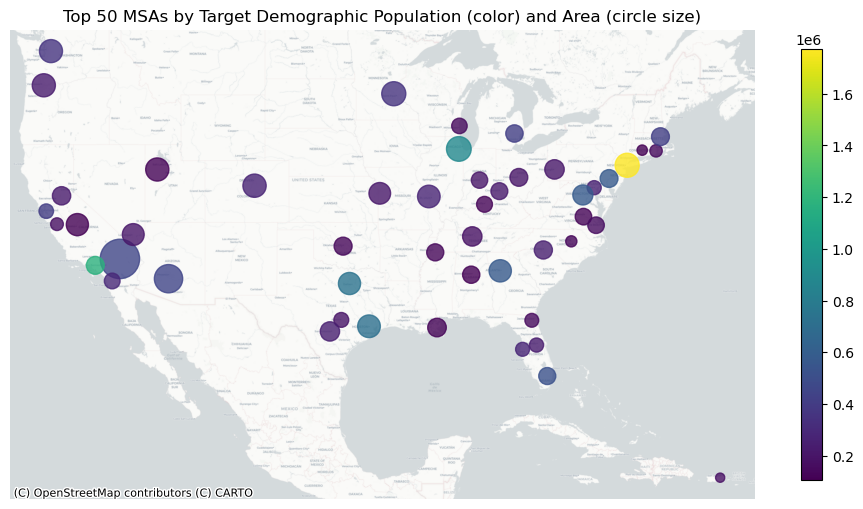

In [17]:
# Importing libraries
import matplotlib.pyplot as plt
import contextily as ctx

# Creating matplotlib map with basemap (contextily)
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting map
merged_gdf.plot(
    ax=ax,
    column="TARGET_DEMO",
    legend=True,
    cmap="viridis",
    markersize=merged_gdf["SQ_MILES"] / 50,
    alpha=0.8,
    legend_kwds={
        "shrink": 0.7
    }
)

# Adding contextily basemap - I was surprised the matplotlib map didn't have a base map by default
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=6)

# Plot title
ax.set_title("Top 50 MSAs by Target Demographic Population (color) and Area (circle size)", fontsize=12)

# Removing anoying axes
ax.axis("off")

# Print result
plt.show()

##### Visualization #2
<br>
This is a clearer visualization to show the total population in each of our MSAs. While it is important to look at the poplation density (later), you also need to keep the total demographic population in mind.

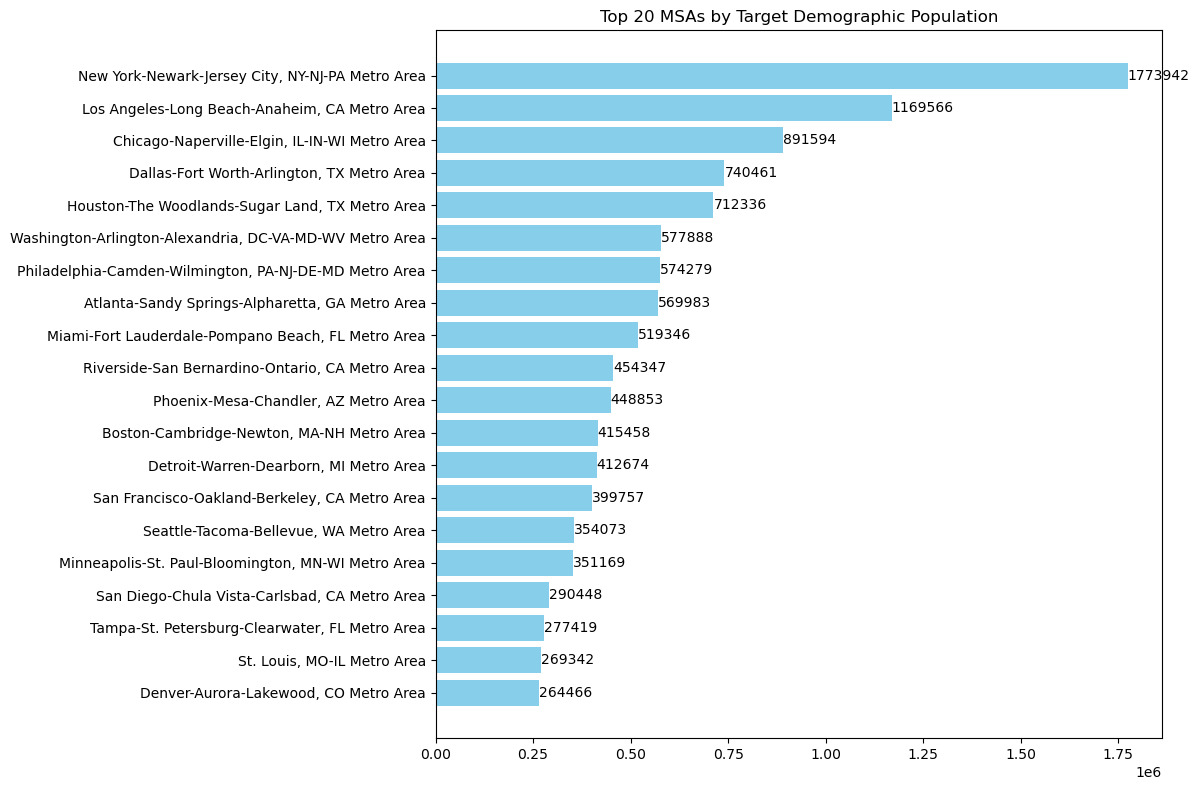

In [19]:
# Filtering (sorting) data frame to top 20 of target demo
top_20_df = combined_df.sort_values(by="TARGET_DEMO", ascending=False).head(20)

# Creating bar graph
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting bar graph
ax.barh(top_20_df["MSA"], top_20_df["TARGET_DEMO"], color="skyblue")

# Adding labels to the bars
for index, value in enumerate(top_20_df["TARGET_DEMO"]):
    ax.text(value + 50, index, str(value), va="center")

# Adding labels to the chart
ax.set_title("Top 20 MSAs by Target Demographic Population", fontsize=12)

# Inverting for better readability
ax.invert_yaxis()

# Print result
plt.tight_layout()
plt.show()

##### Top 20 MSA by Target Demo Population Density
<br>
Here I am filtering geographic and demographic data down to the top twenty

In [21]:
# Creating data frame subset of top 20 by target demo
top_20_pd_df = combined_df.sort_values(by="POP_DENSITY", ascending=False).head(20)

# Changing data type to string
top_20_pd_df["MSA_CODE"] = top_20_pd_df["MSA_CODE"].astype(str)

# Loading shapefile
msa_sf = gpd.read_file("tl_2024_us_cbsa/tl_2024_us_cbsa.shp")

# Changing data type to string
msa_sf["GEOID"] = msa_sf["GEOID"].astype(str)

# Selecting web mercator projection
msa_sf = msa_sf.to_crs(epsg=3857)

# Using centroids for MSA instead of complex geometry
# Tried the complex geometry first and ended up with a 288MB notebook file that crashed python SMH
msa_sf["geometry"] = msa_sf["geometry"].centroid

# Filtering geo data frame to top 50
top_20_geo = msa_sf[msa_sf["GEOID"].isin(top_50_df["MSA_CODE"])].copy()

# Merging filtered data frames
merged2_gdf = top_20_geo.merge(top_20_df, left_on="GEOID", right_on="MSA_CODE")

##### Visualization #3
<br>
Now we are bringing population density into the context of the analysis. This shows the dispersement and relative population densities of our MSAs.

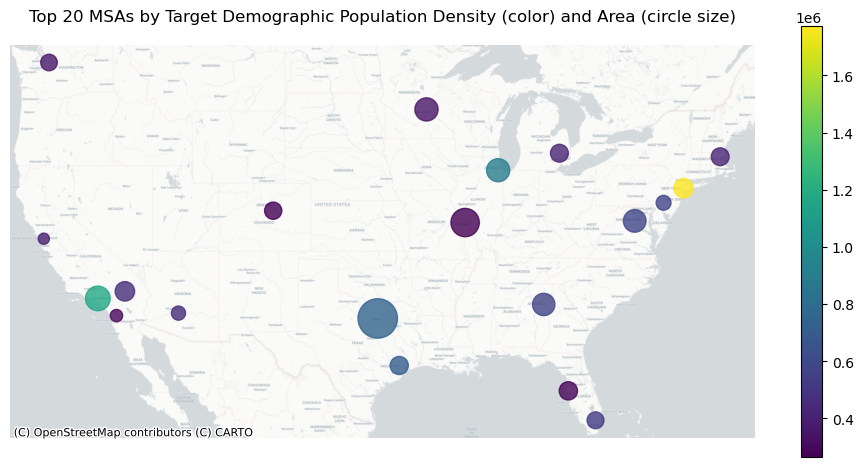

In [23]:
# Creating matplotlib map with basemap (contextily)
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting map
merged2_gdf.plot(
    ax=ax,
    column="TARGET_DEMO",
    legend=True,
    cmap="viridis",
    markersize=merged_gdf["SQ_MILES"] / 50,
    alpha=0.8,
    legend_kwds={
        "shrink": 0.7
    }
)

# Adding contextily basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=6)

# Plot title
ax.set_title("Top 20 MSAs by Target Demographic Population Density (color) and Area (circle size)", fontsize=12)

# Removing anoying axes
ax.axis("off")

# Print result
plt.show()

##### Visualization #4
<br>
Finally, for Milestone 1, this bar chart provides an easier to read and sorted list of the top ten MSAs by population density. It is interesting to compare this list to the top twenty by just population. This kind of context is important for the client's decision making.

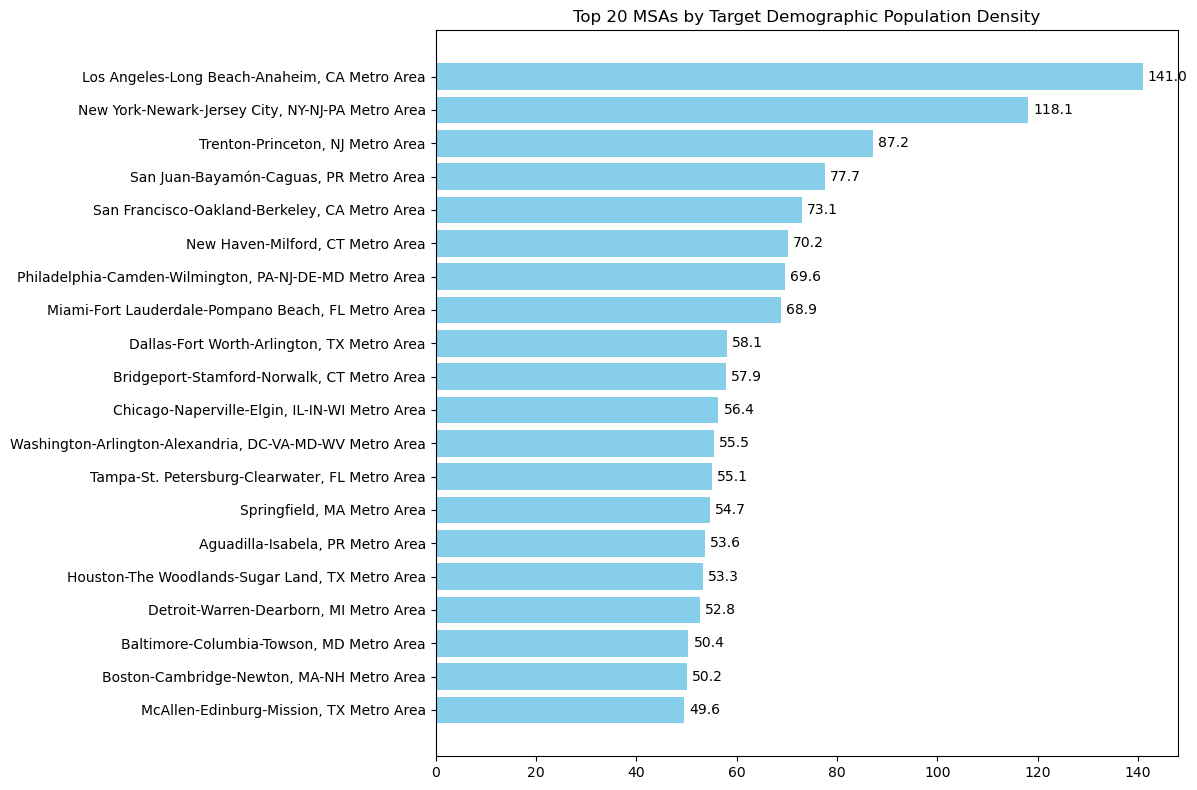

In [25]:
# Creating bar graph
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting bar graph
ax.barh(top_20_pd_df["MSA"], top_20_pd_df["POP_DENSITY"], color="skyblue")

# Adding labels to the bars
for index, value in enumerate(top_20_pd_df["POP_DENSITY"]):
    ax.text(value + 1, index, f"{value:.1f}", va="center")

# Adding labels to the chart
ax.set_title("Top 20 MSAs by Target Demographic Population Density", fontsize=12)

# Inverting for better readability
ax.invert_yaxis()

# Print result
plt.tight_layout()
plt.show()

## Conclusion

This is a good start to this analysis. While it is not the whole picture yet, our client could tell which direction we are going with our analysis if they were to ask for an update at this stage. Next, we need to add in some economic indicators such as median household income. Further on, we might look at getting more granular by examining the data within individual zip codes of the selected MSA markets.

# Milestone 2

### Model Selection
##### I intend to employ a Market Opportunity Scoring Model (MOSM) for this project. This model helps rank potential markets for business expansion.

### Feature expansion

In [31]:
# Adding in median income per MSA
# Ideally, this would have been done in the first API query

# Base API url
census_api_url = "https://api.census.gov/data/2021/acs/acs5"

# Creating query parameters
params = {
    "get": "NAME,B19013_001E",
    "for": "metropolitan statistical area/micropolitan statistical area:*",
    "key": api_key
}

# Fetching data
response = requests.get(census_api_url, params=params)

# Loop to test connection and convert to pandas data frame
if response.status_code == 200 and response.text.strip():
    try:
        data = response.json()
        econ_df = pd.DataFrame(data[1:], columns=data[0])
        
        # Renaming columns
        econ_df.rename(columns={"B19013_001E": "Median_Household_Income", "metropolitan statistical area/micropolitan statistical area": "MSA_CODE"}, inplace=True)
        econ_df["Median_Household_Income"] = pd.to_numeric(econ_df["Median_Household_Income"], errors="coerce")
        
        # Dropping variable
        econ_df.drop(columns=["NAME"], inplace=True)
        
        # Data preview
        print(econ_df.head())

    except requests.exceptions.JSONDecodeError:
        print("Error: Unable to parse JSON. Check API response format.")
else:
    print("Error: API returned an empty response.")

   Median_Household_Income MSA_CODE
0                    64194    10100
1                    53615    10140
2                    57356    10180
3                    55862    10220
4                    60656    10300


### Merging economic data with main data frame

In [33]:
# Merging data
combined_df = pd.merge(combined_df, econ_df, on="MSA_CODE", how="inner")

# Data preview
combined_df.head()

,MSA,MSA_CODE,TARGET_DEMO,SQ_MILES,POP_DENSITY,Median_Household_Income
0,"Aberdeen, SD Micro Area",10100,4368,5851.065395,0.746531,64194
1,"Aberdeen, WA Micro Area",10140,7651,4789.548139,1.597437,53615
2,"Abilene, TX Metro Area",10180,16460,3865.267737,4.258437,57356
3,"Ada, OK Micro Area",10220,3813,1071.411885,3.558855,55862
4,"Adrian, MI Micro Area",10300,9634,1370.075441,7.031730,60656


### Clean up

In [35]:
# Dropping NaNs again (might have some introduced with last merge)
combined_df.dropna(inplace=True)

### Feature Expansion

In [37]:
'''
Filtering data by features to get the top 100 results,
using a min max scaler on population density and
median household income to create a combined score.
'''

# Importing library
from sklearn.preprocessing import MinMaxScaler

# Normalizing features
scaler = MinMaxScaler()
combined_df[["POP_DENSITY_NORM", "Median_Income_NORM"]] = scaler.fit_transform(
    combined_df[["POP_DENSITY", "Median_Household_Income"]]
)

# Combining to create composite score
combined_df["Combined_Score"] = combined_df["POP_DENSITY_NORM"] + combined_df["Median_Income_NORM"]

# Sorting in descending order by composite score
df_sorted = combined_df.sort_values(by="Combined_Score", ascending=False)

# Creating a data frame of the top 100 by composite score
df_top_100 = df_sorted.head(1000) # Expanded for new model below

# Data preview
print(df_top_100)

                                                  MSA MSA_CODE  TARGET_DEMO  \
467     Los Angeles-Long Beach-Anaheim, CA Metro Area    31080      1169566   
571  New York-Newark-Jersey City, NY-NJ-PA Metro Area    35620      1773942   
708     San Francisco-Oakland-Berkeley, CA Metro Area    41860       399757   
709     San Jose-Sunnyvale-Santa Clara, CA Metro Area    41940       177135   
801                  Trenton-Princeton, NJ Metro Area    45940        34186   
..                                                ...      ...          ...   
521                             Minden, LA Micro Area    33380         3642   
212                             Deming, NM Micro Area    19700         2393   
158                         Clarksdale, MS Micro Area    17260         2408   
166                              Coamo, PR Micro Area    17620         2770   
499                           Mayagüez, PR Metro Area    32420         7727   

         SQ_MILES  POP_DENSITY  Median_Household_In

In [38]:
# Cleaning up columns
df_top_100 = df_top_100[["MSA", "MSA_CODE", "TARGET_DEMO", "SQ_MILES", "POP_DENSITY", "Combined_Score", "Median_Household_Income"]]

# Data preview
df_top_100.head()

,MSA,MSA_CODE,TARGET_DEMO,SQ_MILES,POP_DENSITY,Combined_Score,Median_Household_Income
467,"Los Angeles-Long Beach-Anaheim, CA Metro Area",31080,1169566,8297.333847,140.956845,1.534770,81652
571,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",35620,1773942,15016.514187,118.132742,1.412091,86445
708,"San Francisco-Oakland-Berkeley, CA Metro Area",41860,399757,5470.186943,73.079221,1.355642,118547
709,"San Jose-Sunnyvale-Santa Clara, CA Metro Area",41940,177135,4204.761487,42.127241,1.298559,138370
801,"Trenton-Princeton, NJ Metro Area",45940,34186,392.159389,87.173738,1.186143,85687


### Visualization

##### Map of top 100 MSAs using normalized population density and median income.

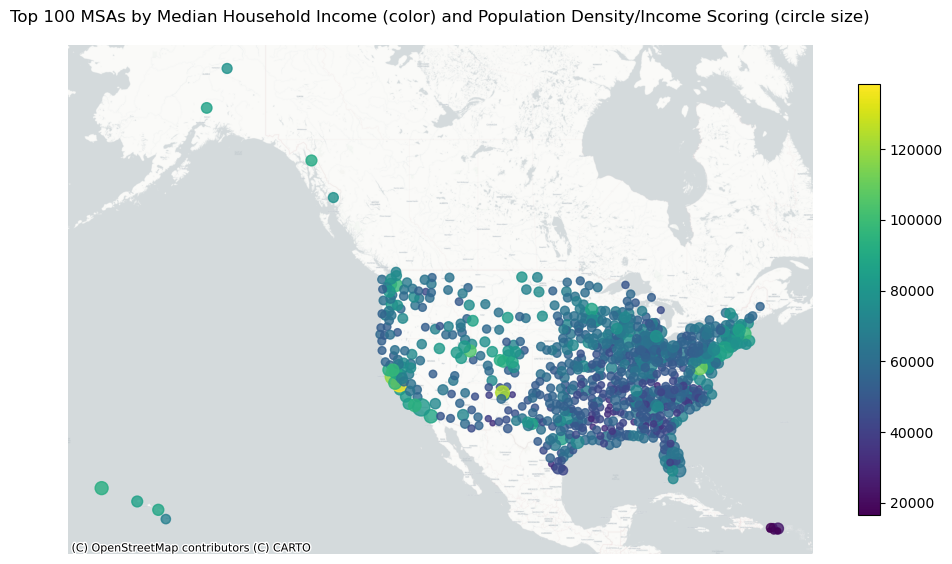

In [48]:
# Filtering geo data frame to top 100
top_100_score_geo = msa_sf[msa_sf["GEOID"].isin(df_top_100["MSA_CODE"])].copy()

# Merging filtered data frames
merged_gdf2 = top_100_score_geo.merge(df_top_100, left_on="GEOID", right_on="MSA_CODE")

# Creating matplotlib map with basemap (contextily)
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting map
merged_gdf2.plot(
    ax=ax,
    column="Median_Household_Income",
    legend=True,
    cmap="viridis",
    markersize=merged_gdf2["Combined_Score"] * 100,
    alpha=0.8,
    legend_kwds={
        "shrink": 0.7
    }
)

# Adding contextily basemap - I was surprised the matplotlib map didn't have a base map by default
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=6)

# Plot title
ax.set_title("Top 100 MSAs by Median Household Income (color) and Population Density/Income Scoring (circle size)", fontsize=12)

# Removing annoying axes
ax.axis("off")

# Print result
plt.show()

# Milestone 3

### Data Frame Cleanup

In [52]:
# Dropping unused columns
df_top_100 = df_top_100[["MSA", "MSA_CODE", "TARGET_DEMO", "POP_DENSITY", "Median_Household_Income"]] # Adding MSA_CODE back in for new join later.

# Renaming columns for readability
df_top_100.rename(columns={"MSA": "Metro_Area", "TARGET_DEMO": "Demographic_Population", "POP_DENSITY": "Population_Density"}, inplace=True)

# Data preview
df_top_100.head()

,Metro_Area,MSA_CODE,Demographic_Population,Population_Density,Median_Household_Income
467,"Los Angeles-Long Beach-Anaheim, CA Metro Area",31080,1169566,140.956845,81652
571,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",35620,1773942,118.132742,86445
708,"San Francisco-Oakland-Berkeley, CA Metro Area",41860,399757,73.079221,118547
709,"San Jose-Sunnyvale-Santa Clara, CA Metro Area",41940,177135,42.127241,138370
801,"Trenton-Princeton, NJ Metro Area",45940,34186,87.173738,85687


### <span style="color:darkred;">Post Milestone 3 Intervention for Better Modeling</span>

Given the feedback I received on Milestone 3, I decided to drop the MOSM model and pursue something that uses the variables we've already engineered compared to a new target variable. Here we are using the percentage of jobs in each MSA that classifies as "high skill" to be an indicator of how economically successful an MSA is. We're combining this normalized and weighted metric with a weighted and normalized median household income.

In [56]:
# Importing library
from scipy.stats import zscore

# ACS variables related to business and economy
acs_variables = [
    "B24011_001E",  # Total workforce population
    "B24011_004E"  # Workforce in management, business, science, and arts
]

params = {
    "get": ",".join(acs_variables),
    "for": "metropolitan statistical area/micropolitan statistical area:*",
    "key": api_key
}

response = requests.get(base_url, params=params)

# Checking response
if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])

    # Convert relevant columns to numeric
    df[acs_variables] = df[acs_variables].apply(pd.to_numeric)

else:
    print(f"Error fetching data: {response.status_code}, {response.text}")

# Renaming columns
df.rename(columns={
    "B24011_001E": "total_workforce",
    "B24011_004E": "high_skill_workforce",
    "metropolitan statistical area/micropolitan statistical area": "MSA_CODE"
}, inplace=True)

# Feature Engineering
df["high_skill_workforce_ratio"] = df["high_skill_workforce"] / df["total_workforce"]

# Normalizing the selected variables using Z-score
df_top_100["Population_Z"] = zscore(df_top_100["Demographic_Population"])
df_top_100["Density_Z"] = zscore(df_top_100["Population_Density"])
df_top_100["Income_Z"] = zscore(df_top_100["Median_Household_Income"])
df["high_skill_z"] = (df["high_skill_workforce_ratio"] - df["high_skill_workforce_ratio"].mean()) / df["high_skill_workforce_ratio"].std()

# Renaming for readability
df.rename(columns={"SUCCESS_SCORE": "Success_Score"}, inplace=True)

# Merging data
df_final = pd.merge(df_top_100, df, on="MSA_CODE", how="inner")

# Compute final success score with some weighting
df_final["Success_Score"] = (df_final["high_skill_z"] * 0.6) + (df_final["Income_Z"] * 0.4)

# Final variable structure
df_final = df_final[["Metro_Area", "Population_Z", "Density_Z", "Income_Z", "Success_Score"]]

# Data preview
df_final.head()

,Metro_Area,Population_Z,Density_Z,Income_Z,Success_Score
0,"Los Angeles-Long Beach-Anaheim, CA Metro Area",10.894960,10.802070,1.775414,1.666489
1,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",16.687164,8.936074,2.145604,1.479199
2,"San Francisco-Oakland-Berkeley, CA Metro Area",3.517284,5.252700,4.625017,2.352409
3,"San Jose-Sunnyvale-Santa Clara, CA Metro Area",1.383725,2.722204,6.156056,3.361489
4,"Trenton-Princeton, NJ Metro Area",0.013734,6.405004,2.087060,2.199217


Now for the modeling. There is naturally some multicollinearity at play in these variables, so we are going to try a Lasso Regression.

Best Alpha: 0.001
Training MSE: 0.3217, R²: 0.4141
Test MSE: 0.2987, R²: 0.3403


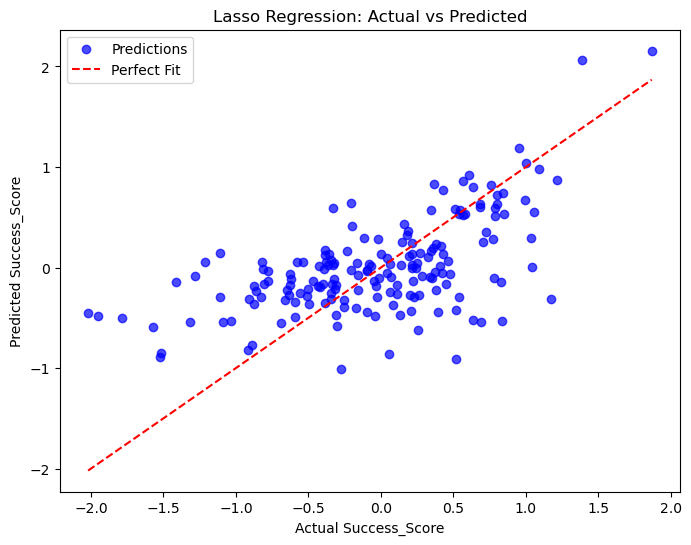

In [59]:
# Importing libraries
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Defining features and target
X = df_final[['Population_Z', 'Density_Z', 'Income_Z']]
y = df_final['Success_Score']

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for alpha (L1 Regularization)
param_grid = {'alpha': np.logspace(-3, 1, 50)}  
lasso = Lasso(max_iter=10000)
grid_search = GridSearchCV(lasso, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_lasso = grid_search.best_estimator_

# Predictions
y_train_pred = best_lasso.predict(X_train)
y_test_pred = best_lasso.predict(X_test)

# Model Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Training MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, R²: {test_r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, label="Predictions", color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Fit")
plt.xlabel("Actual Success_Score")
plt.ylabel("Predicted Success_Score")
plt.title("Lasso Regression: Actual vs Predicted")
plt.legend()
plt.show()

### Setting up Market Opportunity Scoring Model (MOSM) <span style="color:darkred;">OBSOLETE</span>

In [65]:
# Importing library
from scipy.stats import zscore

# Normalizing the selected variables using Z-score
df_top_100["Population_Z"] = zscore(df_top_100["Demographic_Population"])
df_top_100["Density_Z"] = zscore(df_top_100["Population_Density"])
df_top_100["Income_Z"] = zscore(df_top_100["Median_Household_Income"])

# Applying the weighted formula
weights = {"Population_Z": 1, "Density_Z": 0.6, "Income_Z": 0.7}
df_top_100["Market_Opportunity_Score"] = (
    df_top_100["Population_Z"] * weights["Population_Z"] +
    df_top_100["Density_Z"] * weights["Density_Z"] +
    df_top_100["Income_Z"] * weights["Income_Z"]
)

# Sorting by Market Opportunity Score
df_top_100 = df_top_100.sort_values(by="Market_Opportunity_Score", ascending=False)

# Limited to top ten of list
df_top_15 = df_top_100.head(15)

# Data preview
df_top_15.head(15)

,Metro_Area,MSA_CODE,Demographic_Population,Population_Density,Median_Household_Income,Population_Z,Density_Z,Income_Z,Market_Opportunity_Score
571,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",35620,1773942,118.132742,86445,16.687164,8.936074,2.145604,23.550731
467,"Los Angeles-Long Beach-Anaheim, CA Metro Area",31080,1169566,140.956845,81652,10.894960,10.802070,1.775414,18.618992
153,"Chicago-Naperville-Elgin, IL-IN-WI Metro Area",16980,891594,56.381384,78790,8.230939,3.887559,1.554366,11.651531
842,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",47900,577888,55.481818,111252,5.224451,3.814015,4.061584,10.355969
198,"Dallas-Fort Worth-Arlington, TX Metro Area",19100,740461,58.130207,76916,6.782515,4.030535,1.409627,10.187575
708,"San Francisco-Oakland-Berkeley, CA Metro Area",41860,399757,73.079221,118547,3.517284,5.252700,4.625017,9.906416
365,"Houston-The Woodlands-Sugar Land, TX Metro Area",26420,712336,53.339546,72551,6.512971,3.638872,1.072494,9.447040
622,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Me...",37980,574279,69.593529,79070,5.189864,4.967725,1.575992,9.273693
98,"Boston-Cambridge-Newton, MA-NH Metro Area",14460,415458,50.180433,99039,3.667759,3.380597,3.118308,7.878933
514,"Miami-Fort Lauderdale-Pompano Beach, FL Metro ...",33100,519346,68.916787,62870,4.663398,4.912398,0.324778,7.838181


### Conclusion

In Milestone 3 I have cleaned up the columns a bit and employed a Market Opportunity Scoring Model (MOSM) to determine the top 15 markets for ABC Retailer to target with their new retail outlets. First, the model normalizes the data using z scores. Second we apply weights to each variable. I went with 1 for Demographic Population, 0.6 for Population Density, and 0.7 for Median Income. Then we sorted and kept just the top 15 results.